In [1]:
from aicsimageio import AICSImage
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import zarr
from numcodecs import Blosc
import time
import azure.storage.blob

# JAVA is required to read OIR
# pip install bioformats_jar
# apt install default-jdk maven

In [3]:
# load image
filename = 'image_0015'
img = AICSImage(filename + '.oir')

print('1', img.dims.order)
print('2', img.xarray_data.shape)
print('3', img.xarray_data.dtype)
print('4', img.metadata.instruments[0].objectives)

1 TCZYX
2 (1, 3, 1, 512, 512)
3 uint16
4 [Objective(
   id='Objective:0:0',
   model='UPLSAPO 40',
   immersion='Air',
   lens_na=0.95,
   nominal_magnification=40.0,
   working_distance=0.18,
   working_distance_unit='mm',
)]


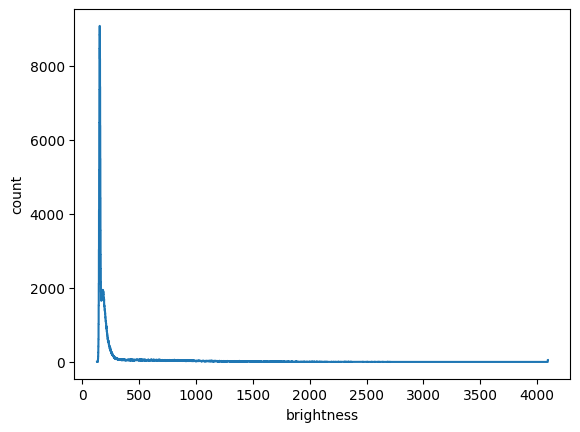

In [4]:
# channel 2 (Actin-FITC) histgram
c = 1
FITC = img.data[0, c, 0, :, :]
bins = FITC.max() - FITC.min()
a_hist, a_bins = np.histogram(FITC, bins=bins)

plt.step(a_bins[:-1], a_hist)
plt.xlabel('brightness')
plt.ylabel('count')
plt.show()

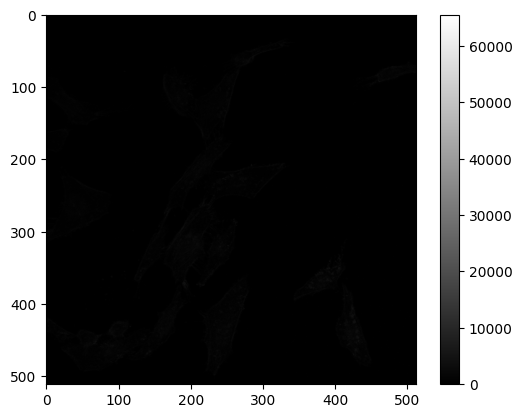

In [5]:
# image is dark when displaying the full range of brightness
fig, ax = plt.subplots()
im = ax.imshow(FITC, cmap='gray', vmin=0, vmax=65535)
fig.colorbar(im, ax=ax)
plt.show()

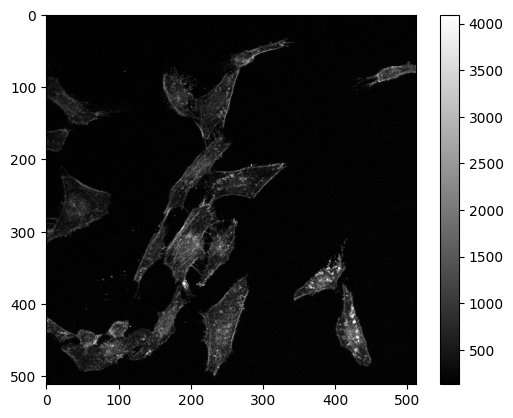

In [6]:
# contrast adjustment
(min, max) = 129, 4095
FITC_cliped = np.clip(FITC, min, max)

fig, ax = plt.subplots()
im = ax.imshow(FITC_cliped, cmap='gray', vmin=min, vmax=max)
fig.colorbar(im, ax=ax)
plt.show()

In [7]:
# assignment of Actin
img.metadata.images[0].pixels.channels[c].color

Color('lime', rgb=(0, 255, 0))

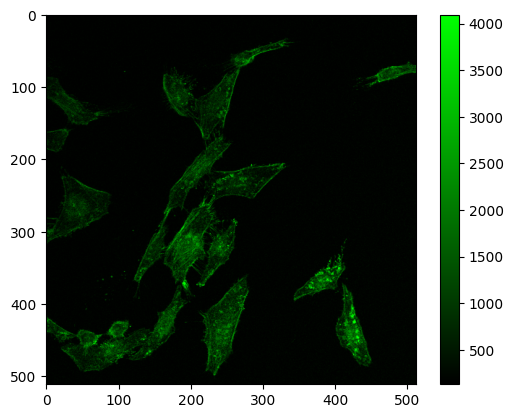

In [8]:
# apply LUT
colors = []
for i in range(256):
    colors.append((0, 256-i, 0))
cmap = ListedColormap(colors)

fig, ax = plt.subplots()
im = ax.imshow(FITC_cliped, cmap=cmap, vmin=min, vmax=max)
fig.colorbar(im, ax=ax)
plt.show()

In [9]:
# save .oir in another file format

# 26MB .oir file (prepare a larger image for loading speed verification)
testfilename = 'coupe_shg_stack_0001'
img = AICSImage(testfilename + '.oir')

# save locally as TIFF
img.save(testfilename + '.tiff')

# save locally as OMT-TIFF
img.save(testfilename + '.ome.tiff')

# save locally as Zarr
# TCZYX : (1, 1, 35, 512, 512)
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
# Compress and save one Z slice of a 256x256 image as one file
chunk_size = (1, 1, 1, 256, 256)
zarray = zarr.array(img.data, chunks=chunk_size, compressor=compressor)
zarr_filename = f'{testfilename}.zarr'
zarr.save(zarr_filename, zarray)

# save to Azure Storage as Zarr
account_name = 'omestorage2'
account_key = 'fiXuQs3aUGoT1Uck/EmsGogeE23D8GtNTNwb9PDKHKcBDeRlgPV6CdQcOlGEnLfEaK/Ylpa/6Nsu+AStq0yOew=='
container_client = azure.storage.blob.ContainerClient(account_url='https://' + account_name + '.blob.core.windows.net/', container_name='data', credential=account_key) 
store = zarr.ABSStore(client=container_client, prefix=f'{testfilename}.zarr')
zarr.save(store, zarray)

In [10]:
# Read speed verification of TIFF and Zarr

18.83116579055786


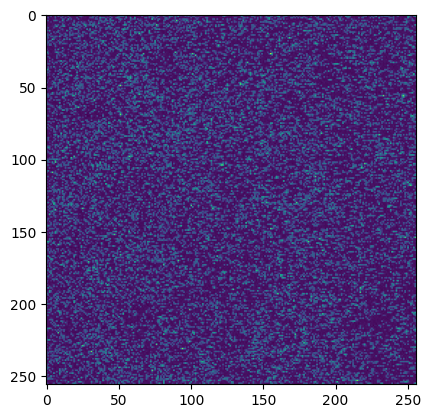

In [11]:
# TIFF
s1 = time.time()

img = AICSImage(f'az://data/{testfilename}.tiff', fs_kwargs={'account_name': account_name, 'account_key': account_key})
plt.imshow(img.data[0, 0, 0, :256, :256])

e1 = time.time()

# Slow because all data is read and then accessed
print(e1 - s1)

0.22387981414794922


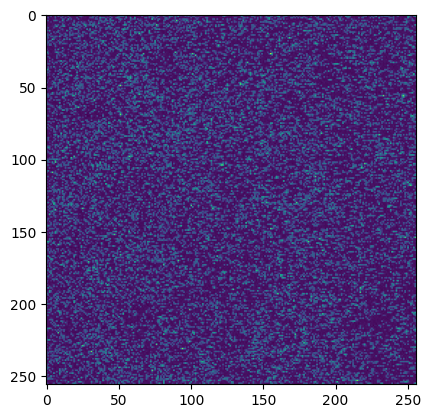

In [12]:
# Zarr
s2 = time.time()

container_client2 = azure.storage.blob.ContainerClient(account_url='https://' + account_name + '.blob.core.windows.net/', container_name='data', credential=account_key) 
store = zarr.ABSStore(client=container_client2, prefix=f'{testfilename}.zarr')  
z = zarr.open(store=store, mode='r')
plt.imshow(z[0, 0, 0, :256, :256])

e2 = time.time()

# Faster as partial access is possible without reading all data
print(e2 - s2)